In [10]:
import rosbag

In [11]:
import pandas as pd

In [12]:
df_lidar0_to_cam0 = pd.read_csv('lidar0-to-cam0-seq-sync.csv')

In [13]:
df_rad0_to_lid0 = pd.read_csv('radar0-to-lidar0-seq-sync.csv')

In [14]:
df_lidar0_to_cam0

,lid0,cam0
0,0,0
1,1,1
2,2,3
3,3,4
4,4,5
...,...,...
1439,1439,1902
1440,1440,1904
1441,1441,1905
1442,1442,1906


In [15]:
df_rad0_to_lid0

,rad0,lid0
0,0,1
1,1,4
2,2,10
3,3,19
4,4,28
...,...,...
345,345,1420
346,346,1423
347,347,1429
348,348,1432


In [22]:
df_rad0_cam =\
    df_rad0_to_lid0.set_index('lid0').join(df_cam0_to_lid0.set_index('lid0')).reset_index().set_index('cam0')
df_rad0_cam

,lid0,rad0
cam0,,
1,1,0
5,4,1
14,10,2
26,19,3
38,28,4
...,...,...
1877,1420,345
1882,1423,346
1889,1429,347


In [23]:
df_cam0_to_lid0.set_index('lid0').loc[[5]].values.reshape(-1)

array([7])

In [24]:
import os

In [25]:
base_dir = 'data'

In [26]:
lidar_dir = os.path.join(base_dir, 'lidar')
cam_dir = os.path.join(base_dir, 'camera')
radar1_dir = os.path.join(base_dir, 'radar1')
radar2_dir = os.path.join(base_dir, 'radar2')

In [27]:
for d in [base_dir, lidar_dir, cam_dir, radar1_dir, radar2_dir ]:
    if not os.path.exists(d):
        print(f'mkdir {d}')
        os.mkdir(d)
        

In [28]:
from velodyne_decoder_pylib import ScanDecoder
import velodyne_decoder as vd

In [29]:
import pickle

In [30]:
import cv2

In [31]:
import numpy as np

In [32]:
cam_topic = '/image_color_rect/compressed'
lidar_topic = '/velodyne_packets'
radar1_topic = '/ti_mmwave/radar_scan_pcl_1'

config = vd.Config(model='VLP-32C')
decoder = ScanDecoder(config)

with rosbag.Bag('/home/devel/Data/lidar_cam_calib_db_project.bag',mode='r') as _bag:
    msg_count = _bag.get_message_count()
    
    # Read rosbag topics
    for topic, msg, t in _bag.read_messages():
        seq = int(msg.header.seq)
        
        # Sensor is a camera (with an assumption the cam0 sequence is unique)
        if (topic == cam_topic) and (seq in df_cam0_to_lid0.cam0.values):
            cam_seq = seq
            fn_seq = f'seq_{seq}'
            rgb = f'{fn_seq}_rgb.png'    
            rgb_path = os.path.join(cam_dir, rgb)    
            #print(f'Dumping cam0 seq {seq} -> {rgb_path}')
            rgb_array = cv2.imdecode(np.frombuffer(msg.data, np.uint8), -1)
            cv2.imwrite(rgb_path, rgb_array)

        # Sensor is a radar
        elif topic == radar1_topic and (seq in df_rad0_cam.rad0.values):
            format_str = '<ffffff'
            ba = bytearray(point_data[field.offset:field.offset + 4])
            data = round(struct.unpack(format_str, ba)[0], 2)

        # Decode the /velodyne_packets.
        elif (topic == lidar_topic) and (seq in df_cam0_to_lid0.lid0.values):
            points = decoder.decode_message(msg, as_pcl_structs=False)
            
            cam_seq = df_cam0_to_lid0.set_index('lid0').loc[[seq]].values.reshape(-1)
            
            for sq in cam_seq:
                fn_seq = f'seq_{sq}'
                lidar = f'{fn_seq}_lidar.pkl'
                lidar_path = os.path.join(lidar_dir, lidar)
                print(f'Dumping cam seq {sq} lidar seq {seq} -> {lidar_path}')
                with open(lidar_path, 'wb') as f:
                    pickle.dump(points, f)
                
    

Dumping cam seq 0 lidar seq 0 -> data/lidar/seq_0_lidar.pkl


AttributeError: '_tf2_msgs__TFMessage' object has no attribute 'header'

In [45]:
from matplotlib import pylab as plt

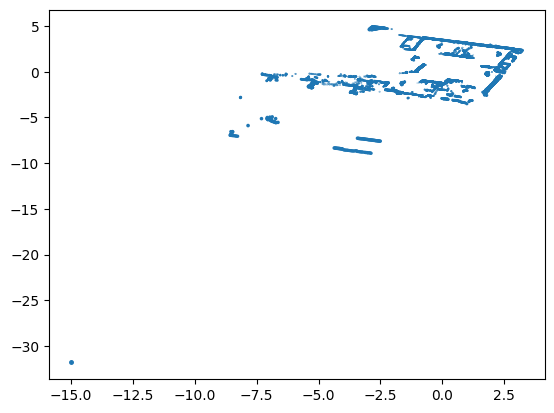

In [51]:
plt.scatter(*points[:,:3].T)